In [1]:
# Core python libraries
import csv
import re
import math
import os
import time

# External libraries.
import nltk
import numpy
import pandas
import scipy
import sklearn
import tempfile

# Tensorflow and related.
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt

# For dynamically reolading modules. imp.reload(module_name) 
import imp

# Internal libraries
import tf_utils

# So you know when this code block finishes.
print ("Done")

Done


In [2]:
#TODO(Max): make a library that does all this preprocessing
data = numpy.genfromtxt('word2vecdf.csv', delimiter=',')
target = numpy.genfromtxt('word2vectargets.csv', delimiter=',')

#data = pandas.read_csv("data/train.csv") # Can read a subset. First nrows of the total.
#LABEL_COLUMN = "SalaryNormalized"

TEST_SIZE = .2

#print("Data shape: (%s, %s)" % data.shape)
#print("Target shape: (%s, %s)" % target.shape)

In [3]:
n_examples = len(data)

# sklearn.cross_validation has been replaced with model_selection.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    data, target, test_size=TEST_SIZE, random_state=42)

# Keep train and test as pandas dataframes.
#X_train = data.iloc[X_train_index]
#X_test = data.iloc[X_test_index]

y_train = Y_train
y_test = Y_test

x_train = X_train
x_test = X_test

print ("Done")
print(X_train.shape)
print(X_test.shape)

print(y_train)

Done
(156776, 300)
(39195, 300)
[ 47000.  21000.  18500. ...,  25000.  15840.  24480.]


In [4]:
# Normalizing input values to mean 0, standard deviation 1.
train_mean, train_std = y_train.mean(), y_train.std()

# Normalize input labels and expectations
y_train = tf_utils.normalize_input(y_train, train_mean, train_std)
y_test = tf_utils.normalize_input(y_test, train_mean, train_std)


In [5]:
# Define data nput functions. These have to be done here as the 
# functions take no arguments. Also the dict labels are specific to 
# the model.
DIMENSIONS = X_train.shape[1]

def input_fn():
    for batch_input, batch_labels in tf_utils.generate_batch(
        batch_size, number_of_batches, DIMENSIONS, x_train, y_train):
        yield {input_data: batch_input, input_target: batch_labels}

def eval_input_fn():
    for batch_input, batch_labels in tf_utils.generate_batch(
        batch_size, number_of_validation_batches, DIMENSIONS, x_test, y_test):
        yield {input_data: batch_input, input_target: batch_labels}


In [6]:
# Define model
#del graph
graph = tf.Graph()

sess = tf.Session(graph=graph)

learning_rate = .01

l1_regularization_coef = 0.0 #1
l2_regularization_coef = 0.0 #1

# Implement this by batch.
batch_size = 512

#(32,16,8) worked well
# (1024, 256, 64) Doesn't work
# (128, 32, 8) Neither
FIRST_LAYER_SIZE = 32
SECOND_LAYER_SIZE = 16
THIRD_LAYER_SIZE = 8

# Given small layers probably need this a little higher.
DROPOUT_KEEP_PROBABILITY = 1.0

with graph.as_default():

    with tf.name_scope("input_data"):
        # Initialize data placeholders
        input_data = tf.placeholder(shape=[batch_size, DIMENSIONS], dtype=tf.float32)
        input_target = tf.placeholder(shape=[batch_size, 1], dtype=tf.float32, name="labels")

    with tf.device('/gpu:0'):

        with tf.name_scope("first_hidden_layer"):
            first_layer_hidden_units = tf.Variable(tf.truncated_normal(shape=[DIMENSIONS, FIRST_LAYER_SIZE], stddev=.5))
            first_layer_bias = tf.Variable(tf.truncated_normal(shape=[1], stddev=.5))
            first_layer_product = tf.matmul(input_data, first_layer_hidden_units)
            first_layer_output = tf.contrib.layers.dropout(
                tf.nn.relu(tf.add(first_layer_product, first_layer_bias)), DROPOUT_KEEP_PROBABILITY)

        with tf.name_scope("output_layer"):
            output_layer_coefficients = tf.Variable(tf.truncated_normal(shape=[FIRST_LAYER_SIZE, 1], stddev=.5))
            output_layer_bias = tf.Variable(tf.truncated_normal(shape=[1], stddev=.5))
            output_layer_product = tf.matmul(first_layer_output, output_layer_coefficients)
            model_output = tf.add(output_layer_product, output_layer_bias, name="predictions")

    with tf.name_scope("loss"):
        # Mean Absolute Error.
        loss = tf.reduce_mean(tf.abs(tf.subtract(input_target, model_output)))

        # If we are using regularization.
        if l1_regularization_coef > 0 or l2_regularization_coef > 0:
            l1_regularizer = tf.contrib.layers.l1_regularizer(scale=l1_regularization_coef)
            l2_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_regularization_coef)

            weights = tf.trainable_variables() # all vars of your graph
            regularization_penalty = tf.add(tf.contrib.layers.apply_regularization(l1_regularizer, weights),
                                             tf.contrib.layers.apply_regularization(l2_regularizer, weights))
            loss = loss + regularization_penalty # this loss needs to be minimized

    with tf.name_scope("reporting"):
        # Converts back to original, salary scale.
        error_salary_scale = tf.multiply(tf.subtract(input_target, model_output), train_std)

        mean_absolute_error_salary_scale = tf.reduce_mean(
            tf.abs(error_salary_scale))

        # Log for tensorboard
        training_summary = tf.summary.scalar('train_loss', loss)
        validation_summary = tf.summary.scalar('validation_loss', loss)
        # Add mean absolute errors.
        training_mae = tf.summary.scalar('train_mae', mean_absolute_error_salary_scale)
        validation_mae = tf.summary.scalar('validation_mae', mean_absolute_error_salary_scale)

    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Declare optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)

    # This one seems to work better :D
    train_op = tf.contrib.layers.optimize_loss(      
     loss, tf.contrib.framework.get_global_step(),      
     optimizer='Adam'
        , learning_rate=learning_rate)


In [10]:
# Number of
#imp.reload(tf_utils)

number_of_epochs = 100000
batches_per_epoch = len(x_train)/batch_size
number_of_batches = math.ceil(len(x_train)/batch_size)
number_of_validation_batches = number_of_batches

logs_dir = "logs/neuralnetworkword2vec"

checkpoint_frequency = 500

reporting_frequency = 3

total_loss = 0
validation_loss = 0
validation_batch_average_window = 100

ckpt = None
ckpt = tf.train.get_checkpoint_state(logs_dir)  

In [ ]:
# Where to save this model.
model_path = os.path.join(logs_dir, time.strftime("%Y-%m-%d-%H-%M-%S"))

import tf_utils
tf_utils = imp.reload(tf_utils)

if ckpt:
    restore_from_model = True
    print("Restore from model!")
else:
    restore_from_model = False

with tf.Session(graph=graph, config=tf.ConfigProto(
    allow_soft_placement=True, log_device_placement=True)) as session:
    summaries = tf.summary.merge_all()                                                       
    writer = tf.summary.FileWriter(model_path,
        graph=session.graph)                  

    saver = tf.train.Saver(tf.global_variables()) 
                                                                                                  
    session.run(tf.global_variables_initializer())
    
    
    if restore_from_model:
        saver.restore(session, ckpt.model_checkpoint_path)
        
    global_step = 0
        
    for epoch in range(number_of_epochs):
        eval_feed_generator = eval_input_fn()
        # Shuffle the training input
        x_train, y_train = tf_utils.unison_shuffled_copies(x_train, y_train)

        for step, feed_dict in enumerate(input_fn()):
            global_step += 1
            start_time = time.time()

            _, temp_loss = session.run([train_op, loss], feed_dict=feed_dict)
            
            duration = time.time() - start_time
            
            if global_step % reporting_frequency == 0:
                print("Epoch: %s Iteration: %s : Loss: %.4f (%.3f sec)" % 
                      (epoch, (step + 1), temp_loss, duration))

                train_summ, train_mae = session.run([training_summary, training_mae], feed_dict=feed_dict)
                writer.add_summary(train_summ, global_step)
                writer.add_summary(train_mae, global_step)
                _, valid_summ, valid_mae = session.run(
                        [loss, validation_summary, validation_mae],
                        feed_dict=next(eval_feed_generator))
                writer.add_summary(valid_summ, global_step)
                writer.add_summary(valid_mae, global_step)

                writer.flush()                

            if (global_step % checkpoint_frequency == 0) or (global_step == number_of_batches):
                print("Saving at epoch %s step: %s" % (epoch, step + 1))
                saver.save(session, model_path, global_step=tf.contrib.framework.get_global_step())

    



Restore from model!
INFO:tensorflow:Restoring parameters from logs/neuralnetworkword2vec/2017-07-02-22-11-38-30500
Epoch: 0 Iteration: 3 : Loss: 0.3934 (0.001 sec)
Epoch: 0 Iteration: 6 : Loss: 0.3663 (0.001 sec)
Epoch: 0 Iteration: 9 : Loss: 0.3996 (0.001 sec)
Epoch: 0 Iteration: 12 : Loss: 0.3666 (0.001 sec)
Epoch: 0 Iteration: 15 : Loss: 0.3974 (0.001 sec)
Epoch: 0 Iteration: 18 : Loss: 0.4209 (0.001 sec)
Epoch: 0 Iteration: 21 : Loss: 0.4090 (0.001 sec)
Epoch: 0 Iteration: 24 : Loss: 0.4383 (0.001 sec)
Epoch: 0 Iteration: 27 : Loss: 0.3621 (0.001 sec)
Epoch: 0 Iteration: 30 : Loss: 0.4085 (0.001 sec)
Epoch: 0 Iteration: 33 : Loss: 0.4046 (0.001 sec)
Epoch: 0 Iteration: 36 : Loss: 0.3613 (0.001 sec)
Epoch: 0 Iteration: 39 : Loss: 0.3887 (0.001 sec)
Epoch: 0 Iteration: 42 : Loss: 0.3771 (0.001 sec)
Epoch: 0 Iteration: 45 : Loss: 0.3918 (0.001 sec)
Epoch: 0 Iteration: 48 : Loss: 0.4350 (0.001 sec)
Epoch: 0 Iteration: 51 : Loss: 0.4180 (0.003 sec)
Epoch: 0 Iteration: 54 : Loss: 0.4238 

In [15]:
# Model Evaluation
# number_of_validation_batches is used above in the eval_input_fn
number_of_validation_batches = math.floor(len(x_test)/batch_size)
# Load checkpointed model.
ckpt = tf.train.get_checkpoint_state(logs_dir)                                     

# Write TF Model Evaluation Code here. 
with tf.Session(graph=graph, config=tf.ConfigProto(
    allow_soft_placement=True, log_device_placement=True)) as session:
    
    saver = tf.train.Saver(tf.global_variables()) 
                                                                                                  
    session.run(tf.global_variables_initializer())
    
    saver.restore(session, ckpt.model_checkpoint_path)
    prediction_array_list = []

    total_loss = 0
    for step, eval_feed_dict in enumerate(eval_input_fn()):    
        valid_loss, mae, model_predictions = session.run(
            [loss, mean_absolute_error_salary_scale, model_output], feed_dict=eval_feed_dict)
        #print("Batch: %d Mean: %.4f" % (step, mae))
        total_loss += mae
        prediction_array_list.append(model_predictions)
    print ("Mean Absolute Error Loss over all %s observations = %s" % ((step + 1) * batch_size, total_loss / (step + 1)))

INFO:tensorflow:Restoring parameters from logs/neuralnetworkword2vec/2017-07-01-19-30-44-3500
Mean Absolute Error Loss over all 36864 observations = 12967.8136936


In [33]:
def flatten_predictions(predictions):
    return numpy.concatenate(predictions)

predictions = flatten_predictions(prediction_array_list)

n_predictions = predictions.shape[0]

actuals = y_test[0:n_predictions]

print(n_predictions, actuals.shape)
print(y_test)

51200 (51200,)
[ 0.89645004 -0.66550416  3.22435188 ..., -0.29010177  0.89645004
  0.95295256]


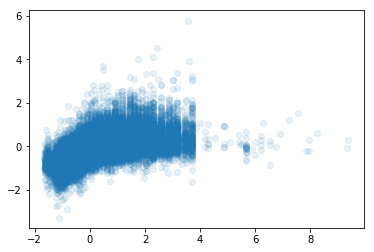

[[ 0.41440365 -1.14755058  2.74230552 ...,  2.3354876  -0.51788706
  -0.85690188]
 [ 1.37059236 -0.1913619   3.6984942  ...,  3.29167628  0.43830159
   0.09928676]
 [ 0.58996278 -0.97199142  2.91786456 ...,  2.51104665 -0.34232792
  -0.68134272]
 ..., 
 [ 0.9635421  -0.5984121   3.29144382 ...,  2.88462591  0.03125139
  -0.30776343]
 [ 0.63640022 -0.92555392  2.96430206 ...,  2.55748415 -0.29589045
  -0.63490528]
 [ 1.41444039 -0.14751387  3.74234223 ...,  3.33552432  0.48214963
   0.1431348 ]]


In [37]:
%matplotlib inline

def print_results(x_vals, y_vals):

    plt.scatter(x_vals, y_vals, alpha=.1)
    plt.show()

    print(x_vals-y_vals)
    #print(sorted([set(y_vals)]))

print_results(actuals, predictions)

In [30]:
# Quick random forest digression.
from sklearn import ensemble
clf = ensemble.RandomForestRegressor(n_jobs=-1, n_estimators=10)

clf.fit(x_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [32]:
predictions = clf.predict(x_test)
print(predictions.shape)

mae = sklearn.metrics.mean_absolute_error(y_test, predictions)

print(mae)
print(mae * train_std)

(34297,)
0.534623520375
9450.87215019


In [10]:
print(Y_train.shape)
print(Y_test.shape)
print("Guess the average MAE: %.2f" % numpy.mean(numpy.abs(Y_test - train_mean)))

(156776,)
(39195,)
Guess the average MAE: 13406.63
